In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from multiprocessing import Pool
sys.path.append('../Module_Analysis/')
import Pair_Corelation_Function as PCF
#import Clustering as Clust
sys.path.append('/home/hcleroy/PostDoc/aging_condensates/Simulation/Gillespie/Gillespie_backend')
import Gillespie_backend as backend
import Simulate_System as SimSys
sys.path.append('/home/hcleroy/Extra_Module_py/')
import formated_matplotlib

## On the emergence of multiple clusters
In this notebook, we investigate whether multiple cluster can form throughout the equilibration. It seems that the higher is the binding energy, the less ergodic the system become. Notice that longer polymer requires larger binding energy to reach the same state. We still have to find a "good" definition of clustering, in order to clearly make this point. If we can characterize the clustering in few parameters, we will be able to systematically test their value for a range of binding energy. Notice that I just used the number of timestep to asses the time of equilibration. Which should be converted in real time.

In [3]:
# define the unit of the system :
dimension = 3

L = 1000
NLinker = 10

Eb = -30.

kdiff = 0.000207352*5

seed = np.random.randint(0,1000000)

In [3]:
Sys = backend.Gillespie(  ell_tot=L,
                    rho0=0.,
                    BindingEnergy=Eb,
                    kdiff=kdiff,
                    seed = seed,
                    Nlinker=NLinker,dimension=dimension) 

In [4]:
Sys.evolve(10**6)

(array([1, 1, 1, ..., 0, 1, 3]),
 array([7.31207725e+01, 8.68170695e+01, 2.69353546e+00, ...,
        7.97825241e+11, 4.33655078e+01, 9.48672484e+00]))

(<Figure size 334.646x251.613 with 1 Axes>,
 <Axes3D: xlabel='x', ylabel='y', zlabel='z'>)

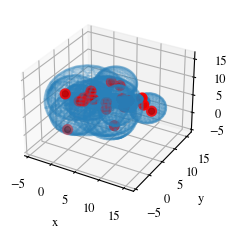

In [5]:
Sys.Plot3DGillespie()

# Clustering methods

In [4]:
from sklearn.cluster import KMeans
from kneed import KneeLocator
def split_data_per_cluster(kmeans,data):
    """
    Given a kmeans object that we used to split the data into clusters.
    The data are then splitted according to the cluster where the belong.
    """
    data_out = []
    for i in range(kmeans.n_clusters):   
        kmeans.labels_
        data_out.append(data[np.argwhere(kmeans.labels_==i)[:,0]])
    return data_out
def compute_dist_vector(array):
    """
    return a 1D vector of distance between the points in the array.
    The shape of the array must be Nx3, where N is the number of points
    """
    if array.shape[0]==1:
        # return an unique 0 to allow the computation of the mean
        return np.array([0.])
    dists = np.zeros(array.shape[0]*(array.shape[0]-1)//2,dtype=float)
    k=0
    for i in range(array.shape[0]):
        for j in range(i):
            dists[k] = np.linalg.norm(array[i]-array[j])
            k+=1
    return dists
def compute_mutual_distance(A1,A2):
    """
    return a 1D vector of distance between the two arrays.
    """
    dists = np.zeros(A1.shape[0]*A2.shape[0],dtype=float)
    k=0
    for a1 in A1:
        for a2 in A2:
            dists[k] = np.linalg.norm(a1-a2)
            k+=1
    return dists

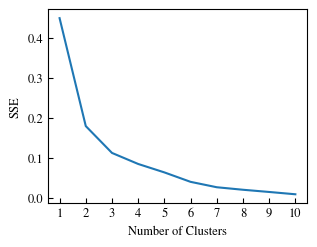

3


In [7]:
# find the correct number of cluster:
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(Sys.get_R())
    sse.append(kmeans.inertia_)
plt.plot(range(1, 11), np.array(sse)/sum(sse))
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
print(kl.elbow)

In [8]:
nc = kl.elbow
kmeans = KMeans(n_clusters=nc)
kmeans.fit(Sys.get_R())

KMeans(n_clusters=3)

In [9]:
data_splitted = split_data_per_cluster(kmeans,Sys.get_R())

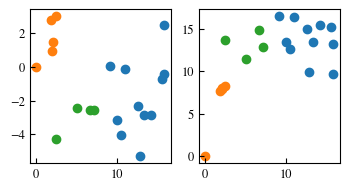

In [10]:
fig,ax = plt.subplots(ncols=2,figsize=(4,2))
for i in range(data_splitted.__len__()):
    ax[0].scatter(data_splitted[i][:,0],data_splitted[i][:,1])
    ax[1].scatter(data_splitted[i][:,0],data_splitted[i][:,2])

In [11]:
for i in range(data_splitted.__len__()):
    print("average distance between points in the cluster "+str(i)+" = "+str(np.mean(compute_dist_vector(data_splitted[i]))))
print()
for i in range(data_splitted.__len__()):
    for j in range(i+1,data_splitted.__len__()):
        print("average distance between the clusters "+str(i)+" and the cluster "+str(j)+" = "+str(np.mean(compute_mutual_distance(data_splitted[i],data_splitted[j]))))

average distance between points in the cluster 0 = 5.233158335726132
average distance between points in the cluster 1 = 4.2641042752885845
average distance between points in the cluster 2 = 3.628239147639068

average distance between the clusters 0 and the cluster 1 = 14.40762517137593
average distance between the clusters 0 and the cluster 2 = 8.343887095873908
average distance between the clusters 1 and the cluster 2 = 9.488534647177428


In [5]:
import networkx as nx

In [6]:
def weight(distance):
    if distance != 0:
        return 1/distance
    else :
        return 0.
def make_adjacency_matrix(array):
    adjacency = np.zeros((array.shape[0], array.shape[0]),dtype=float)
    for i in range(array.shape[0]):
        for j in range(i+1,array.shape[0]):
            adjacency[i,j] = weight(np.linalg.norm(array[i]-array[j]))
            adjacency[j,i] = adjacency[i,j]
    return adjacency
def clustering_coefficient(A):
    graph = nx.from_numpy_matrix(A)
    weighted_clustering_coef = nx.clustering(graph,weight='weight')
    return sum(weighted_clustering_coef.values()) / len(weighted_clustering_coef)

def clustering_distrib(A):
    graph = nx.from_numpy_matrix(A)
    return nx.clustering(graph,weight='weight').values()

In [7]:
Sys_5 = backend.Gillespie(  ell_tot=L,
                    rho0=0.,
                    BindingEnergy=-10,
                    kdiff=kdiff,
                    seed = seed,
                    Nlinker=NLinker,dimension=dimension)
Sys_30 = backend.Gillespie(  ell_tot=L,
                    rho0=0.,
                    BindingEnergy=-30,
                    kdiff=kdiff,
                    seed = seed,
                    Nlinker=NLinker,dimension=dimension)

In [8]:
move_5,time_5 = Sys_5.evolve(10**6)

In [11]:

print('1')
move_30,time_30 = Sys_30.evolve(10**6)

1


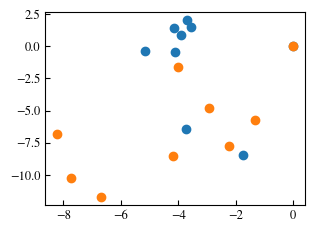

In [18]:
plt.scatter(Sys_5.get_R()[:,0],Sys_5.get_R()[:,1])
plt.scatter(Sys_30.get_R()[:,0],Sys_30.get_R()[:,1])

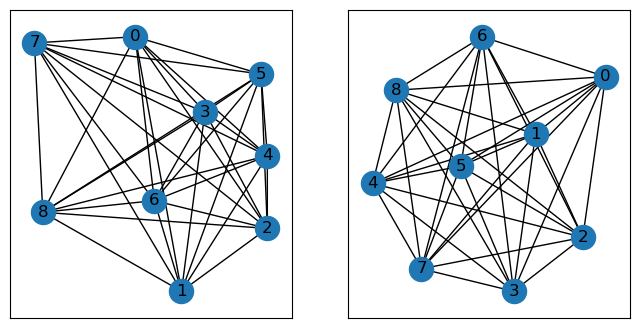

In [12]:
G_10 = nx.from_numpy_matrix(make_adjacency_matrix(Sys_5.get_R()))
G_30 = nx.from_numpy_matrix(make_adjacency_matrix(Sys_30.get_R()))
fig,ax = plt.subplots(ncols=2,figsize=(8,4))
nx.draw_networkx(G_10,with_labels=True,ax=ax[0])
nx.draw_networkx(G_30,with_labels=True,ax=ax[1])

In [13]:
print(clustering_coefficient(make_adjacency_matrix(Sys_5.get_R())))
print(clustering_coefficient(make_adjacency_matrix(Sys_30.get_R())))

0.21003690387992757
0.2951512772822404


0.08384356121426499


(array([1., 0., 0., 1., 1., 2., 4., 5., 2., 4.]),
 array([0.05098054, 0.05577125, 0.06056195, 0.06535266, 0.07014336,
        0.07493407, 0.07972477, 0.08451548, 0.08930618, 0.09409689,
        0.09888759]),
 <BarContainer object of 10 artists>)

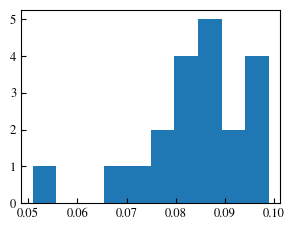

In [55]:
print(clustering_coefficient(make_adjacency_matrix(Sys.get_R())))
plt.hist(clustering_distrib(make_adjacency_matrix(Sys.get_R())))

In [49]:
# test : 
A =np.zeros((6,6),dtype=float)
A[0,1] = 4
A[0,2] = 2
A[1,2] = 4
A[1,3] = 1
A[1,4] = 2
A[4,5] = 1
A = (A+A.T)
graph = nx.from_numpy_matrix(A)
#subax = plt.subplot()
#pos=nx.spring_layout(graph)
#nx.draw_networkx(graph,with_labels=True)
#labels = nx.get_edge_attributes(graph,'weight')
#nx.draw_networkx_edge_labels(graph,pos,edge_labels=labels)
weighted_clustering_coef = nx.clustering(graph,weight='weight')
weighted_avg_clustering_coef = sum(weighted_clustering_coef.values()) / len(weighted_clustering_coef)

print("Weighted clustering coefficients:", weighted_clustering_coef)
print("Weighted average clustering coefficient:", weighted_avg_clustering_coef)
# test : 
A =np.zeros((6,6),dtype=float)
A[0,1] = 1
A[0,2] = 2
A[1,2] = 1
A[1,3] = 4
A[1,4] = 2
A[4,5] = 4
A = (A+A.T)
graph = nx.from_numpy_matrix(A)
#subax = plt.subplot()
#pos=nx.spring_layout(graph)
#nx.draw_networkx(graph,with_labels=True)
#labels = nx.get_edge_attributes(graph,'weight')
#nx.draw_networkx_edge_labels(graph,pos,edge_labels=labels)
weighted_clustering_coef = nx.clustering(graph,weight='weight')
weighted_avg_clustering_coef = sum(weighted_clustering_coef.values()) / len(weighted_clustering_coef)

print("Weighted clustering coefficients:", weighted_clustering_coef)
print("Weighted average clustering coefficient:", weighted_avg_clustering_coef)



Weighted clustering coefficients: {0: 0.7937005259840998, 1: 0.13228342099734997, 2: 0.7937005259840998, 3: 0, 4: 0, 5: 0}
Weighted average clustering coefficient: 0.28661407882759155


The clustering measurement seems to work, let us adapt it to the array of position of the linkers